# COVID-19 Vaccinations and LifeModes

## <i> Jacob Seboly, Esra Ozdenerol

### Data Preparation

In [4]:
pip install sodapy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

#### County Dataset
This county-level dataset comes from ESRI's Tapestry data. It provides the dominant LifeMode for each U.S. county as well as the number of households in the county classified for each LifeMode.

In [7]:
county_file_path = "https://raw.githubusercontent.com/jseboly/COVID_VAX_LMS/main/counties.csv?token=AWAL2PY2LTLTD2BF5PKC4XLBRVXI6"

In [8]:
counties_orig = pd.read_csv(county_file_path)

In [6]:
#The relevant columns are: the county FIPS code, the dominant LifeMode number, and the number of households in each LifeMode.
co = counties_orig.iloc[:,[1,7,79,80,81,82,83,84,85,86,87,88,89,90,91,92]]

In [7]:
#rename the columns to shorter, clearer names 
co = co.rename(columns = {'ID':'FIPS', 'TLIFECODE':'DLM', 'THHGRPL1':'LM1', 'THHGRPL2':'LM2', 'THHGRPL3':'LM3', 'THHGRPL4':'LM4',
                         'THHGRPL5':'LM5', 'THHGRPL6':'LM6', 'THHGRPL7':'LM7', 'THHGRPL8':'LM8', 'THHGRPL9':'LM9', 'THHGRPL10':'LM10',
                         'THHGRPL11':'LM11', 'THHGRPL12':'LM12', 'THHGRPL13':'LM13', 'THHGRPL14':'LM14'})

In [8]:
#Convert FIPS field to integer to facilitate join later
co["FIPS"] = pd.to_numeric(co["FIPS"])

<i>Column names:</i>
<br>FIPS = FIPS code
<br>DLM = dominant lifemode
<br>LM1 = households belonging to LifeMode 1;
<br>and so on for all 14 LifeModes

Preparation of the county dataset is complete.

#### Vaccination Data
"COVID Vaccinations in the United States, County" Source: CDC <br> Information: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh <br> Contains vaccinations by county, new record added for each county every day. 

In [9]:
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# First 5000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("8xkx-amqh", limit=5000)

# Convert to pandas DataFrame
vax_orig = pd.DataFrame.from_records(results)

In [10]:
#The relevant columns to be selected are date, FIPS, and the number of fully vaccinated people (series_complete_yes), 
#and the percentage of fully vaccinated people compared to eligible population
vx = vax_orig.iloc[:,[0,1,6,8]]

In [11]:
#rename the columns to shorter, clearer names 
vx = vx.rename(columns = {'date':'Date', 'fips':'FIPS', 'series_complete_yes':'FV', 'series_complete_12pluspop':'FV%'})

<i>Column names:</i>
<br>Date = Date and Time
<br>FIPS = FIPS code
<br>FV = number fully vaccinated
<br>FV% = percentage of eligible population fully vaccinated
<br>EP = total eligible population

In [12]:
#Subset the rows with FIPS not missing
vx = vx[vx.FIPS != 'UNK']

In [13]:
vx["FV"] = pd.to_numeric(vx["FV"])
vx["FV%"] = pd.to_numeric(vx["FV%"])
vx["Date"] = pd.to_datetime(vx["Date"])
vx["FIPS"] = pd.to_numeric(vx["FIPS"])

In [14]:
#Select only the observations for the most recent date
today = '2021-10-15' #always use two days ago- record date will be one day ago
vx = vx[(vx['Date'] > today) & (vx['Date'] <= '2021-12-31')]

In [15]:
#add a new column representing the total over-12 population
vx['EP'] = vx['FV'] * 100 / vx['FV%']
vx['EP'] = round(vx['EP'], 0)

<b>Now the LifeMode data and vaccination data are joined together based on FIPS.

In [16]:
df = pd.merge(co, vx, how='left', on='FIPS')

In [17]:
df[1:11]

,FIPS,DLM,LM1,LM2,LM3,LM4,LM5,LM6,LM7,LM8,LM9,LM10,LM11,LM12,LM13,LM14,Date,FV,FV%,EP
1,1003,10,2233,0,0,20781,13287,10095,0,8339,7293,25013,0,1230,0,0,2021-10-17,97604,50.7,192513.0
2,1003,10,2233,0,0,20781,13287,10095,0,8339,7293,25013,0,1230,0,0,2021-10-16,97393,50.6,192476.0
3,1005,10,0,0,0,600,809,528,0,0,0,5557,401,1909,0,0,2021-10-17,9228,43.1,21411.0
4,1005,10,0,0,0,600,809,528,0,0,0,5557,401,1909,0,0,2021-10-16,9162,42.8,21407.0
5,1007,10,0,0,0,0,0,0,0,453,0,6990,0,674,0,0,2021-10-17,6825,35.0,19500.0
6,1007,10,0,0,0,0,0,0,0,453,0,6990,0,674,0,0,2021-10-16,6802,34.9,19490.0
7,1009,10,0,0,0,1000,569,2168,0,0,0,17826,0,600,0,0,2021-10-17,15868,32.2,49280.0
8,1009,10,0,0,0,1000,569,2168,0,0,0,17826,0,600,0,0,2021-10-16,15832,32.2,49168.0
9,1011,10,0,0,0,0,0,0,0,0,0,3846,0,0,0,0,2021-10-17,4470,51.5,8680.0
10,1011,10,0,0,0,0,0,0,0,0,0,3846,0,0,0,0,2021-10-16,4456,51.4,8669.0


<b> Data Preparation Complete

### Exploratory Data Analysis

First, we examine the distribution of the fully vaccinated people variable.

In [18]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [20]:
import matplotlib.pyplot as plt

In [21]:
df['FV'].describe()

count    4.780000e+03
mean     5.064928e+04
std      1.946894e+05
min      0.000000e+00
25%      3.117000e+03
50%      9.185000e+03
75%      2.804300e+04
max      6.112843e+06
Name: FV, dtype: float64

In [22]:
df['FV%'].describe()

count    4708.000000
mean       46.130076
std        19.832391
min         0.000000
25%        38.900000
50%        49.000000
75%        58.700000
max        99.900000
Name: FV%, dtype: float64

#### Descriptive Stats for Fully Vaccinated by County
| Stat        | Raw Count   | Percentage |
| ----------- | ----------- | ---------- |
| Mean        | 50,760      | 46.2%      |
| St. Dev.    | 186,909     | 19.7%      |
| Minimum     | 0           | 0.0%       |
| 25%         | 3,121       | 39.1%      |
| Median      | 9,272       | 49.0%      |
| 75%         | 27,621      | 58.6%      |
| Maximum     | 6,106,572   | 99.9%      |

Text(0, 0.5, 'Counties')

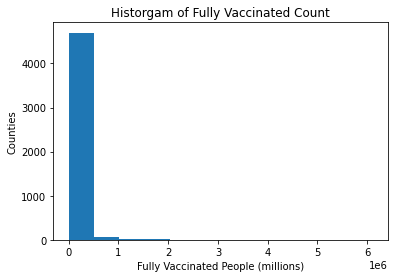

In [23]:
fig, ax = plt.subplots()
ax.hist(df['FV'], bins=12)
ax.set_title('Historgam of Fully Vaccinated Count')
ax.set_xlabel('Fully Vaccinated People (millions)')
ax.set_ylabel('Counties')

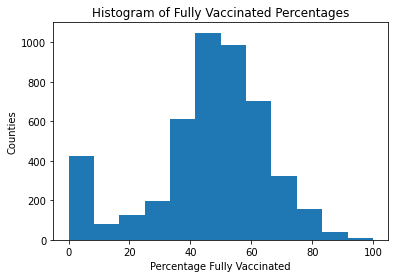

In [24]:
plt.hist(df['FV%'], bins=12)
plt.title('Histogram of Fully Vaccinated Percentages')
plt.xlabel('Percentage Fully Vaccinated')
plt.ylabel('Counties')
plt.show()

Note the distribution for raw count is extremely right-skewed; this is because it is based on county populations. The distribution for percentage is slightly left-skewed, indicating that there are more counties with low vaccination percentages balanced by a few counties with very high vaccination percentages. Finally, the mean vaccination percentage by county is significantly lower than the percentage for the U.S. overall, indicating that the counties with low vaccination rates are generally smaller (in population) than the counties with high vaccination rates.

In [28]:
df.corr()

,FIPS,DLM,LM1,LM2,LM3,LM4,LM5,LM6,LM7,LM8,LM9,LM10,LM11,LM12,LM13,LM14,FV,FV%,EP
FIPS,1.000000,-0.067856,-0.042364,-0.055027,-0.033916,-0.044215,-0.006328,0.061871,-0.050134,-0.037713,-0.104694,-0.019727,-0.030342,-0.036211,-0.047350,-0.014218,-0.081673,-0.209671,-0.069202
DLM,-0.067856,1.000000,-0.293021,-0.141604,-0.061129,-0.229904,-0.189289,-0.266327,-0.044088,-0.131893,-0.072841,0.385998,-0.064511,0.015548,0.003689,0.040110,-0.130568,-0.254165,-0.123491
LM1,-0.042364,-0.293021,1.000000,0.730892,0.487749,0.630291,0.489286,0.172894,0.617592,0.689872,0.562655,0.062467,0.563832,0.311805,0.509133,0.359391,0.755680,0.180144,0.818839
LM2,-0.055027,-0.141604,0.730892,1.000000,0.680586,0.231853,0.167320,0.019156,0.521891,0.655661,0.412691,-0.000084,0.367737,0.205346,0.789024,0.254752,0.836131,0.134171,0.825291
LM3,-0.033916,-0.061129,0.487749,0.680586,1.000000,0.192313,0.174503,0.013725,0.461460,0.652766,0.379244,0.006613,0.559486,0.330391,0.768133,0.254056,0.744674,0.092673,0.744366
LM4,-0.044215,-0.229904,0.630291,0.231853,0.192313,1.000000,0.554621,0.335425,0.606287,0.532805,0.477698,0.204108,0.584442,0.317987,0.191985,0.335447,0.470745,0.136345,0.561276
LM5,-0.006328,-0.189289,0.489286,0.167320,0.174503,0.554621,1.000000,0.513161,0.283458,0.565965,0.559332,0.101043,0.522651,0.625209,0.144988,0.370759,0.475217,0.239849,0.510781
LM6,0.061871,-0.266327,0.172894,0.019156,0.013725,0.335425,0.513161,1.000000,0.097777,0.214425,0.263780,0.129171,0.154649,0.315079,0.025196,0.167650,0.209006,0.260881,0.233424
LM7,-0.050134,-0.044088,0.617592,0.521891,0.461460,0.606287,0.283458,0.097777,1.000000,0.557748,0.475008,0.148586,0.581071,0.267096,0.628530,0.257098,0.649422,0.014043,0.803214
LM8,-0.037713,-0.131893,0.689872,0.655661,0.652766,0.532805,0.565965,0.214425,0.557748,1.000000,0.609166,0.074588,0.831330,0.461367,0.649100,0.431669,0.857288,0.205503,0.878703
